# ENSDF Nuclear Level Density Interpolation

In the effort to use ML to predict cross section data, a very important feature that comes to mind are the nuclear levels. These are directly correlated to resonance location. How can we represent available data correctly and incorporate it into our EXFOR datasets? In this example, we go through a very simple approach where we load the cut-off ENSDF dataset and fit linear models to available nuclear level densities. It is not only the predictions that we save but also the models since we need to query them at the EXFOR datapoint energies.

In [2]:
# # Prototype
# import sys
# sys.path.append("../..")

In [4]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

import logging
import os

import nucml.datasets as nuc_data
import nucml.ensdf.plot as ensdf_plot
import nucml.ensdf.data_utilities as ensdf_utils
import nucml.ame.parsing_utilities as ame_utils
import nucml.model.model_building as model_building
import nucml.general_utilities as gen_utils

In [5]:
figure_dir = "../Figures/"

With the modules imported, let us load the RIPL-cut ENSDF data.

In [7]:
ensdf_cutoff_df = nuc_data.load_ensdf_ml(cutoff=True, log=True, append_ame=True, basic=-1, num=False)

INFO:root:Dropping Ground State...
INFO:root:AME: Reading and loading Atomic Mass Evaluation files from: 
 C:/Users/Pedro/Desktop/ML_Nuclear_Data/AME/CSV_Files\AME_all_merged_no_NaN.csv
INFO:root:Finished. Resulting dataset has shape (20825, 75)


Also, let us create a unique ID for each dataset:

In [13]:
ensdf_cutoff_df["ID"] = ensdf_cutoff_df.Z.astype(str) + "_" + ensdf_cutoff_df.A.astype(str)
unique_ids = ensdf_cutoff_df.ID.unique()

## Fitting a Linear Model to NLD ENSDF Cut-Off Data 

In [15]:
pred_v1 = ensdf_utils.generate_level_density_csv(ensdf_cutoff_df, 92, 233, plot=True)

INFO:root:Extracting samples from dataframe.


KeyError: 'Protons'

The same function as above is being used but this time I am giving the total number of levels to generate. 

INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (36, 77)
INFO:root:Generating level density for 233U
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (36, 77)
INFO:root:Expanded Dataset has shape: (500, 76)


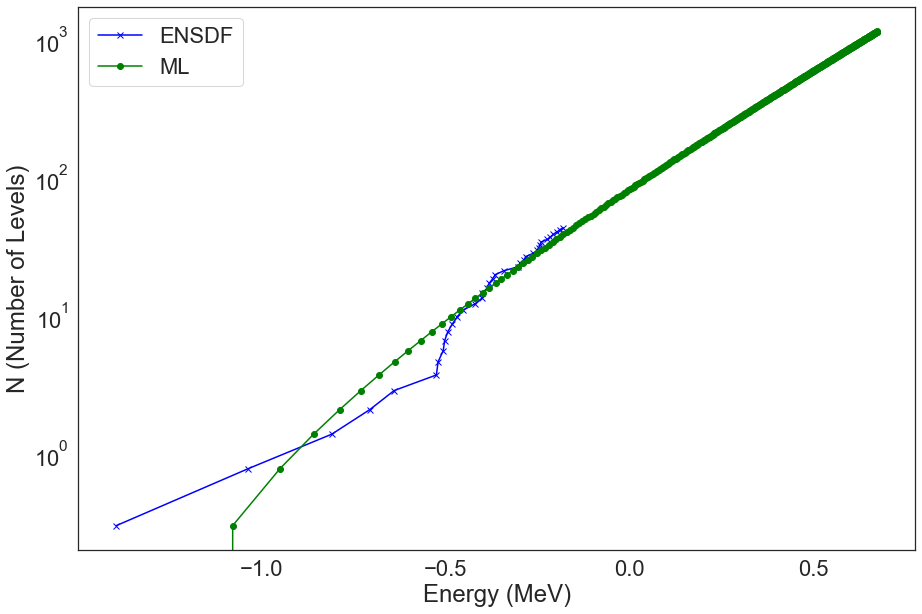

In [70]:
pred_v1 = ensdf_utils.generate_level_density_csv(ensdf_cutoff_df, 92, 233, tot_num_levels=500, plot=True)

What if we want to get the NLD datapoints until a certain MeV. The model is trained to predict the energy given an level number. We cannot just use the model to predict NLD although you could fit a linear model also to the generated NLD. That makes more sence but here I will opt for brute force. My purpose is to use this datapoints to append to EXFOR therefore I wrote a function that will keep increasing levels until the predicted energy reaches 20 MeV. Let us obtain the NLD for U233.

In [73]:
# Since each iteration will generate a lot of output we will turn off the logger for now
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

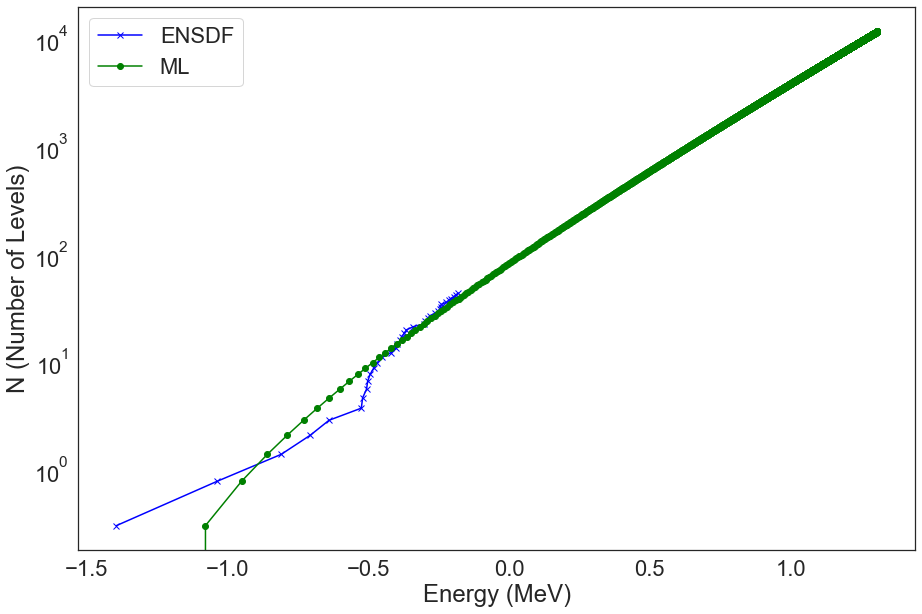

In [169]:
pred_v1 = ensdf_utils.generate_level_density_csv(ensdf_cutoff_df, 92, 233, tot_num_levels=500,
                                                 # Notice I want to get the NLD up to a certain energy
                                                 # so we set get_upper=True and the target upper_energy_mev 
                                                 # to 20 MeV. The it_limit means how many times should we 
                                                 # increase the tot_num_levels by 100 before giving up. 
                                                 get_upper=True, upper_energy_mev=20, it_limit=500, 
                                                 plot=True)

We can use this function to iterate through all elements in the ensdf_cutoff_df dataframe. The same function allows for us to save predicted datapoints as a CSV for later use. 

In [92]:
# This list will allow us to obtain those isotopes for which we could not reach the target energy
not_reached = []

for i in unique_ids:
    Z, A = i.split("_")
    df_str = ensdf_utils.generate_level_density_csv(ensdf_cutoff_df, int(Z), int(A), save=True, tot_num_levels=500, 
                                                    get_upper=True, upper_energy_mev=20, it_limit=500,
                                                    saving_dir="../CSV_Files/Level_Density/")
    if type(df_str) == str:
        not_reached.append(df_str)

not_reached

[]

You will notice that the not_reached is empty. I found that 500 tot_num_levels and it_limit of 500 allowed enough iterations for every element to reach 20 MeV. We can take a look at the directory and see that we succesfully generated various isotopic files with level density data.

In [76]:
os.listdir("../CSV_Files/Level_Density/")[:10]

['100Mo_Level_Density.csv',
 '100Ru_Level_Density.csv',
 '101Ru_Level_Density.csv',
 '102Pd_Level_Density.csv',
 '102Ru_Level_Density.csv',
 '103Rh_Level_Density.csv',
 '103Ru_Level_Density.csv',
 '104Pd_Level_Density.csv',
 '104Rh_Level_Density.csv',
 '104Ru_Level_Density.csv']

In [170]:
pred_v1

,Level_Number,Level_Energy,N
0,0.000000,-1.297970,0.000000
1,0.301030,-1.078108,0.301030
2,0.477121,-0.949497,0.778151
3,0.602060,-0.858246,1.380211
4,0.698970,-0.787467,2.079181
...,...,...,...
3695,3.567732,1.307778,11583.367894
3696,3.567849,1.307864,11586.935744
3697,3.567967,1.307950,11590.503711
3698,3.568084,1.308036,11594.071795


In [171]:
def transform_back(df):
    df["Level_Number"] = 10**df.Level_Number.values
    df["Level_Energy"] = 10**df.Level_Energy.values
    return df

pred_v1_nolog = transform_back(pred_v1.copy())

In [172]:
pred_v1_nolog

,Level_Number,Level_Energy,N
0,1.0,0.050353,0.000000
1,2.0,0.083539,0.301030
2,3.0,0.112332,0.778151
3,4.0,0.138597,1.380211
4,5.0,0.163130,2.079181
...,...,...,...
3695,3696.0,20.313199,11583.367894
3696,3697.0,20.317213,11586.935744
3697,3698.0,20.321227,11590.503711
3698,3699.0,20.325240,11594.071795


In [174]:
pred_v1_nolog = pred_v1_nolog.append({"Level_Number": 0, "Level_Energy": 0, "N": 0}, ignore_index=True).sort_values(by="Level_Number").reset_index(drop=True)

In [176]:
pred_v1_nolog.iloc[1,2] = np.nan

In [177]:
pred_v1_nolog["N"] = pred_v1_nolog.N.interpolate()

In [178]:
pred_v1_nolog.head()

,Level_Number,Level_Energy,N
0,0.0,0.000000,0.000000
1,1.0,0.050353,0.150515
2,2.0,0.083539,0.301030
3,3.0,0.112332,0.778151
4,4.0,0.138597,1.380211


In [150]:
pred_v1_nolog.set_index('Level_Energy', inplace=True)

In [151]:
pred_v1_nolog.head()

,Level_Number,N
Level_Energy,,
0.000000,0.0,0.000000
0.050353,1.0,0.150515
0.083539,2.0,0.301030
0.112332,3.0,0.778151
0.138597,4.0,1.380211


In [159]:
new_to_append = pd.DataFrame({"Level_Number":[np.nan], "Level_Energy": [0.03], "N":[np.nan]}).set_index('Level_Energy')

In [160]:
new_to_append

,Level_Number,N
Level_Energy,,
0.03,NaN,NaN


In [161]:
pred_v1_nolog.append(pd.DataFrame({"Level_Number":[np.nan], "Level_Energy": [0.03], "N":[np.nan]}).set_index('Level_Energy')).sort_index()

,Level_Number,N
Level_Energy,,
0.000000,0.0,0.000000
0.030000,NaN,NaN
0.050353,1.0,0.150515
0.083539,2.0,0.301030
0.112332,3.0,0.778151
...,...,...
20.313199,3696.0,11583.367894
20.317213,3697.0,11586.935744
20.321227,3698.0,11590.503711


In [195]:
def get_level_density(energy_mev, pred_df, log=False):
    if log:
        energy = np.log10(energy_mev)
    else:
        energy = energy_mev

    to_append = pd.DataFrame({"Level_Number":[np.nan], "Level_Energy": [energy], "N":[np.nan]})
    to_interpolate = pred_df.append(to_append)
    to_interpolate = to_interpolate.set_index('Level_Energy').sort_index()
    to_interpolate.interpolate(method='index', inplace=True)
    to_interpolate = to_interpolate.reset_index()
    return to_interpolate[to_interpolate.Level_Energy == energy].N.to_numpy()
    
#     new_index = len(to_interpolate) - 1
#     to_interpolate = to_interpolate.interpolate()
#     level_density = to_interpolate.loc[new_index]["N"]
#     return level_density

nld = get_level_density(0.03, pred_v1_nolog.copy())
nld

array([0.089675])